# Wrangle Data from WeRateDogs with the Twitter API


**Goal:** wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

Find at least **8 quality issues** and **2 tidiness issues**. Provide at least **3 insights** and **1 visualization** after data wrangling.

In [220]:
import numpy as np
import pandas as pd
import requests
import itertools
import os
import json
from datetime import datetime
import statsmodels.api as sm

#matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

# Scientific libraries
#from numpy import arange, array, ones
from scipy import stats

In [1]:
import dill
#dill.dump_session('notebook_session.db')
dill.load_session('notebook_session.db')

# GATHER

In [19]:
#read in the WeRateDogs twitter archive
arc = pd.read_csv('./data/twitter-archive-enhanced.csv')

In [20]:
#install breed predictions of a neural network for dogs
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open(os.path.join('./data/', url.split('/')[-1]), mode='wb') as file:
    file.write(r.content)

In [21]:
image_predictions = pd.read_csv('./data/image-predictions.tsv', sep='\t')

So for the last row under `image-predictions.tsv`:

- tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921

- p1 is the algorithm's #1 prediction for the image in the tweet → **golden retriever**

- p1_conf is how confident the algorithm is in its #1 prediction → **95%**

- p1_dog is whether or not the #1 prediction is a breed of dog → **TRUE**

- p2 is the algorithm's second most likely prediction → **Labrador retriever**

- p2_conf is how confident the algorithm is in its #2 prediction → **1%**

- p2_dog is whether or not the #2 prediction is a breed of dog → **TRUE**
etc.

> Use Tweepy (Twitter API) for each tweet's JSON data using the tweet IDs under the WeRateDogs archive.

In [22]:
#handle environment variables
from os.path import join, dirname
from dotenv import load_dotenv

path = './weratedogs-env-vars.env'
load_dotenv(dotenv_path = path, verbose = True)

True

In [23]:
#create API object
import tweepy

consumer_key = os.getenv('CONSUMER_KEY')
consumer_secret = os.getenv('CONSUMER_SECRET')
access_token = os.getenv('TOKEN')
access_secret = os.getenv('TOKEN_SECRET')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
#save JSON tweet data to tweet-json.txt
tweet_ids = arc.tweet_id
num_success = 0
num_errors = 0

start_time = datetime.now()

with open('./data/logs/error-file.txt', 'w', encoding='utf-8') as errfile:
    with open('./data/tweet-json.txt', 'w', encoding='utf-8') as outfile:
        for tweet_id in tweet_ids:
            try: 
                tweet = api.get_status(tweet_id)
                tweet_json = json.dumps(tweet._json)
                json.dump(tweet_json, outfile)
                outfile.write('\n')
                num_success += 1
                print(tweet_id)
            except tweepy.TweepError as e:
                err_string = '{}: {}'.format(tweet_id, e.args[0][0]['message'])
                errfile.write(err_string)
                errfile.write('\n')
                num_errors += 1
                print(err_string)
                continue
        
time_elapsed = datetime.now() - start_time

print('Time elapsed (hh:mm:ss:ms): {}'.format(time_elapsed))
print('Valid tweets: {}'.format(num_success))
print('Invalid tweets: {}'.format(num_errors))

In [24]:
#read tweet_json data into a list of tweet JSONs
all_tweets = []

for line in open('./data/tweet-json.txt', 'r', encoding = 'utf-8'):
    json_data = json.loads(json.loads(line))
    all_tweets.append(json_data)

In [25]:
#pick interesting fields to add to DataFrame
all_tweets[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]},


In [26]:
#create dictionary to use in pandas DataFrame
tweets_json = []
for tweet in all_tweets:
    tweets_json.append({'tweet_id': tweet['id'],
                     'created_at': tweet['created_at'],
                      'favorite_count': tweet['favorite_count'],
                      'retweet_count': tweet['retweet_count']
                     })

In [27]:
tweets_json[0]

{'tweet_id': 892420643555336193,
 'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'favorite_count': 37424,
 'retweet_count': 8130}

In [28]:
#create Pandas DataFrame
tweet_fields = pd.DataFrame(tweets_json, columns = ['tweet_id', 'created_at', 'favorite_count', 'retweet_count'])

In addition to `tweet_id`, `created_at`, and `retweet_count`, I also decided to add the additional fields `created_at` and `followers_count` for the user. This is because I want to examine how the other variables such as `favorite_count` and `retweet_count` could impact the fluctuation of followers, and also see which time of the day under `created_at` gives the biggest spike in followers.

# ASSESS

In [29]:
arc.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/890006608113172480/photo/1",13,10,Koda,None,None,None,None
189,855860136149123072,8.558585e+17,13615722.0,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck https://t.co/rf661IFEYP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690899218434/photo/1,13,10,Grizzwald,None,floofer,None,None
2059,671186162933985280,NaN,NaN,2015-11-30 04:37:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sparky. That's his pancake now. He will raise it as his own. 10/10 https://t.co/96tMaWyoWt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671186162933985280/photo/1,10,10,Sparky,None,None,None,None
1924,674075285688614912,NaN,NaN,2015-12-08 03:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Mitch. He thinks that's a hat. Nobody has told him yet. 11/10 please no one tell him https://t.co/7jOPktauh4,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674075285688614912/photo/1,11,10,Mitch,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None
1313,706904523814649856,NaN,NaN,2016-03-07 18:09:06 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Ever seen a dog pet another dog? Both 13/10 truly an awe-inspiring scene. (Vid by @mdougherty20) https://t.co/3PoKf6cw7f,NaN,NaN,NaN,https://vine.co/v/iXQAm5Lrgrh,13,10,None,None,None,None,None
879,760641137271070720,NaN,NaN,2016-08-03 00:59:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Theo. He can walk on water. Still coming to terms with it. 12/10 magical af https://t.co/8Kmuj6SFbC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760641137271070720/photo/1,12,10,Theo,None,None,None,None
743,780459368902959104,NaN,NaN,2016-09-26 17:29:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bear. Don't worry, he's not a real bear tho. Contains unreal amounts of squish. 11/10 heteroskedastic af https://t.co/coi4l1T2Sm",NaN,NaN,NaN,https://twitter.com/dog_rates/status/780459368902959104/photo/1,11,10,Bear,None,None,None,None
1309,707059547140169728,NaN,NaN,2016-03-08 04:25:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Sa

In [30]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [31]:
#look at denominators that are not equal to 10
arc.query('rating_denominator != 10').head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None


In [32]:
#check counts of denominators != 10
arc.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [33]:
#check corresponding text with denominators != 10
denoms = arc[arc['rating_denominator'] != 10][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]
pd.set_option('display.max_colwidth', -1)
denoms

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [34]:
#check non-int numerators
arc.query('rating_numerator == 75 or rating_numerator == 26')[['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [35]:
#look at nonsensical dog names
mask = arc.name.str.islower()
bad_names = arc.loc[mask]['name'].sample(50)
bad_names.sample(50)

822     just      
1737    a         
2335    an        
773     very      
819     very      
1040    actually  
2264    a         
1095    mad       
2191    a         
2346    the       
1941    a         
1138    all       
2314    a         
2249    a         
2116    a         
1994    a         
2333    an        
2030    space     
1049    a         
1031    very      
2212    the       
1854    a         
169     quite     
992     his       
1097    very      
2334    a         
1747    officially
2350    a         
2311    a         
1120    this      
801     a         
1207    a         
1368    a         
649     a         
682     mad       
1004    a         
1499    a         
1603    the       
1853    a         
2222    a         
1361    a         
2347    a         
2034    a         
2128    a         
1002    a         
1936    one       
1785    a         
1527    the       
118     quite     
2326    quite     
Name: name, dtype: object

In [36]:
#check for number of dogs that fall under more than 1 dog stage
def mask_duplicate_stages(df):
    stage_mask = []
    for i, row in df.iterrows():
        sum = 0
        if (row['doggo'] != 'None'):
            sum += 1
        if (row['floofer'] != 'None'):
            sum += 1
        if (row['pupper'] != 'None'):
            sum += 1
        if (row['puppo'] != 'None'):
            sum += 1

        if sum > 1:
            stage_mask.append(True)
        else:
            stage_mask.append(False)
    
    return stage_mask

In [37]:
def mask_single_stages(df):
    stage_mask = []
    for i, row in df.iterrows():
        sum = 0
        if (row['doggo'] != 'None'):
            sum += 1
        if (row['floofer'] != 'None'):
            sum += 1
        if (row['pupper'] != 'None'):
            sum += 1
        if (row['puppo'] != 'None'):
            sum += 1

        if sum == 1:
            stage_mask.append(True)
        else:
            stage_mask.append(False)
    
    return stage_mask

In [38]:
def mask_all_stages(df):
    stage_mask = []
    for i, row in df.iterrows():
        sum = 0
        if (row['doggo'] != 'None'):
            sum += 1
        if (row['floofer'] != 'None'):
            sum += 1
        if (row['pupper'] != 'None'):
            sum += 1
        if (row['puppo'] != 'None'):
            sum += 1

        if sum > 0:
            stage_mask.append(True)
        else:
            stage_mask.append(False)
    
    return stage_mask

In [39]:
#create masks
dup_stage_mask = mask_duplicate_stages(arc)    
single_stage_mask = mask_single_stages(arc)
all_stage_mask = mask_all_stages(arc)

In [40]:
#number of dogs with more than 1 stage
arc[dup_stage_mask].shape[0]

14

In [41]:
#number of dogs with only 1 stage
arc[single_stage_mask].shape[0]

366

In [42]:
#number of dogs with >= 1 stage
arc[all_stage_mask].shape[0]

380

In [45]:
#check for text associated with each tweet showing > 1 stage
arc[dup_stage_mask][['tweet_id', 'text', 'doggo', 'floofer', 'pupper', 'puppo']]

,tweet_id,text,doggo,floofer,pupper,puppo
191,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggo,None,None,puppo
200,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggo,floofer,None,None
460,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",doggo,None,pupper,None
531,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggo,None,pupper,None
565,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggo,None,pupper,None
575,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggo,None,pupper,None
705,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,doggo,None,pupper,None
733,781308096455073793,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",doggo,None,pupper,None
778,775898661951791106,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,None,pupper,None
822,770093767776997377,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggo,None,pupper,None


In [46]:
#check for retweets and duplicates
arc[~(arc.retweeted_status_id.isnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" re

In [50]:
#check 1 instance to verify that these retweets are, in fact, duplicates
arc[arc.text.str.contains('Canela')][['tweet_id', 'text']]

,tweet_id,text
19,888202515573088257,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX
23,887473957103951883,This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX


In [49]:
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1654,810254108431155201,https://pbs.twimg.com/media/Cz6Z0DgWIAAfdvp.jpg,1,Staffordshire_bullterrier,0.292556,True,American_Staffordshire_terrier,0.261233,True,Border_terrier,0.062375,True
1045,712809025985978368,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True
127,668268907921326080,https://pbs.twimg.com/media/CUYrBNQUkAA-zx4.jpg,1,Pembroke,0.484830,True,Cardigan,0.425303,True,basenji,0.014753,True
711,685315239903100929,https://pbs.twimg.com/media/CYK6kf0WMAAzP-0.jpg,2,chow,0.470162,True,Pomeranian,0.159677,True,Eskimo_dog,0.105074,True
1511,786233965241827333,https://pbs.twimg.com/media/CulDnZpWcAAGbZ-.jpg,1,Labrador_retriever,0.478193,True,schipperke,0.224817,True,Staffordshire_bullterrier,0.077396,True
1589,798628517273620480,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1,beagle,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True
1402,768970937022709760,https://pbs.twimg.com/ext_tw_video_thumb/768967618174877700/pu/img/4wfsrs0ZnQ5pstXm.jpg,1,Pomeranian,0.182358,True,golden_retriever,0.110658,True,mousetrap,0.086399,False
1809,832757312314028032,https://pbs.twimg.com/media/C46MWnFVYAUg1RK.jpg,2,Cardigan,0.160888,True,Staffordshire_bullterrier,0.159441,True,Boston_bull,0.154368,True
420,674042553264685056,https://pbs.twimg.com/media/CVquIDRW4AEJrPk.jpg,1,toy_poodle,0.927975,True,miniature_poodle,0.068946,True,standard_poodle,0.001316,True
1065,715680795826982913,https://pbs.twimg.com/media/Ce6b4MPWwAA22Xm.jpg,1,golden_retriever,0.990715,True,Labrador_retriever,0.002228,True,chow,0.001197,True


In [51]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [52]:
image_predictions.shape[0]

2075

In [55]:
#check for tweet_ids in common between 2 DataFrames
def find_common_tweet_ids(df1, df2):
    common = df1.merge(df2, on = ['tweet_id'])
    return common

In [56]:
#check for tweet_ids NOT in common between 2 DataFrame
def find_missing_tweet_ids(df1, df2):
    missing = df1[(~df1.tweet_id.isin(df2.tweet_id))]
    return missing

In [57]:
#check for common and missing tweet_ids between arc and image_predictions
common = find_common_tweet_ids(arc, image_predictions)
missing = find_missing_tweet_ids(arc, image_predictions)

In [58]:
print(common.tweet_id.tail(5))
print(missing.tweet_id.tail(5))

2070    666049248165822465
2071    666044226329800704
2072    666033412701032449
2073    666029285002620928
2074    666020888022790149
Name: tweet_id, dtype: int64
2038    671550332464455680
2149    669684865554620416
2189    668967877119254528
2212    668587383441514497
2298    667070482143944705
Name: tweet_id, dtype: int64


In [59]:
#check if the sum of len(common) and len(missing) equals the entire length of arc
len(arc), len(common) + len(missing)

(2356, 2356)

In [60]:
#check for missing tweet_ids between arc and tweet_fields
common1 = find_common_tweet_ids(arc, tweet_fields)
missing1 = find_missing_tweet_ids(arc, tweet_fields)

In [61]:
print(common1.tweet_id.tail(5))
print(missing1.tweet_id.tail(5))

2329    666049248165822465
2330    666044226329800704
2331    666033412701032449
2332    666029285002620928
2333    666020888022790149
Name: tweet_id, dtype: int64
566     802247111496568832
784     775096608509886464
818     770743923962707968
932     754011816964026368
1726    680055455951884288
Name: tweet_id, dtype: int64


In [62]:
#check if the sum of len(common1) and len(missing1) equals the entire length of arc
len(arc), len(common1) + len(missing1)

(2356, 2356)

In [64]:
#check for missing ids in common between image_predictions and tweet_fields (IDs not present in arc)
common3 = find_common_tweet_ids(missing, missing1)

In [65]:
print(common3.tweet_id)

0    872668790621863937
1    869988702071779329
2    866816280283807744
3    856602993587888130
4    845459076796616705
5    827228250799742977
6    812747805718642688
7    775096608509886464
8    770743923962707968
Name: tweet_id, dtype: int64


In [66]:
#check number of missing ids in common
len(common3)

9

In [68]:
len(image_predictions.query('p1_conf >= 0.95'))

266

In [69]:
#check if timestamps in twitter archive and scraped tweets are consistent
time_const = arc[['tweet_id', 'timestamp']]
time_const = pd.merge(time_const, tweet_fields, on = 'tweet_id', how = 'left')

time_const.sample(20)

,tweet_id,timestamp,created_at,favorite_count,retweet_count
273,840728873075638272,2017-03-12 00:59:17 +0000,Sun Mar 12 00:59:17 +0000 2017,0.0,16872.0
2032,671763349865160704,2015-12-01 18:50:38 +0000,Tue Dec 01 18:50:38 +0000 2015,1677.0,931.0
961,751132876104687617,2016-07-07 19:16:47 +0000,Thu Jul 07 19:16:47 +0000 2016,5247.0,1370.0
1823,676533798876651520,2015-12-14 22:46:41 +0000,Mon Dec 14 22:46:41 +0000 2015,1902.0,571.0
248,845397057150107648,2017-03-24 22:08:59 +0000,Fri Mar 24 22:08:59 +0000 2017,7818.0,1869.0
69,879050749262655488,2017-06-25 18:56:45 +0000,Sun Jun 25 18:56:45 +0000 2017,21818.0,4522.0
1280,708834316713893888,2016-03-13 01:57:25 +0000,Sun Mar 13 01:57:25 +0000 2016,1732.0,525.0
1339,704871453724954624,2016-03-02 03:30:25 +0000,Wed Mar 02 03:30:25 +0000 2016,4400.0,1160.0
454,818536468981415936,2017-01-09 19:14:36 +0000,Mon Jan 09 19:14:36 +0000 2017,11415.0,2642.0
184,856526610513747968,2017-04-24 15:13:52 +0000,Mon Apr 24 15:13:52 +0000 2017,11821.0,1896.0


## Quality ##

**`arc`**:

**Missing Data**

- `arc` contains 281 tweets that are missing from `image_predictions`.
- `arc` contains 22 tweets that are missing from `tweet_fields`. After dropping previous entries, there should be 13 tweets to be dropped.


- retweeted data indicates duplicated tweets.
- unnecessary anchor tags under **source**
- erroneous datatypes under **in_reply_to_status_id**, **in_reply_to_user_id**, **retweeted_status_id**, **retweeted_status_user_id**, **timestamp**, and **retweeted_status_timestamp**.
- inconsistent & inaccurate readings mapped from text to numerator & denominator fields (e.g. 24/7 being mistaken as a rating).
- some numerator values contain a decimal point (e.g. 9.75/10).
- **rating_denominator** has values besides 10
- nonsensical dog names such as *a, an, quite, by, actually, such, not, one*.
- inconsistent timestamp format between `arc` and `tweet_fields`.
- there is one entry with no rating.

## Tidiness

**`arc`**:

- **doggo**, **floofer**, **pupper**, and **puppo** all are not under 1 category variable.
- **favorite_count** and **retweet_count** fields under `tweet_fields` need to be merged with `arc`.
- **p1**, **p1_conf**, and **p1_dog** under `image_predictions` need to be merged with `arc`
- dog breeds under the **p1** column have untidy formatting.

In [229]:
#before cleaning, create a clean copy of each DataFrame
arc_clean = arc.copy()
img_clean = image_predictions.copy()
tweets_clean = tweet_fields.copy()

## CLEAN

### Quality

> **Issue 1:** `arc` contains 281 tweets that are missing from `image_predictions.`

**Define**

Drop the tweets_ids from `arc` that are not present in `image_predictions`.


**Code**

In [230]:
missing_clean = find_missing_tweet_ids(arc_clean, img_clean)

missing_ids = missing_clean.tweet_id
arc_clean = arc_clean[(arc_clean.tweet_id.isin(img_clean.tweet_id))]

**Test**

In [231]:
#verify that 281 entries have been dropped from arc_clean
arc.shape[0] - arc_clean.shape[0]

281

> **Issue 1a:** `arc` contains 22 tweets that are missing from `tweet_fields.` After dropping the previous entries, there should be 13 tweets to be dropped.

**Define**

Drop the tweets_ids from `arc` that are not present in `tweet_fields`.

From the previous step, there 9 dropped tweet IDs in common with the missing IDs in `tweet_fields.` Excluding these tweets that were already dropped, there should be 22 - 9 = **13 tweets** dropped after this step, accounting for a **total 294 entries dropped.** (281 + 13)


**Code**

In [232]:
missing_clean2 = find_missing_tweet_ids(arc_clean, tweets_clean)

missing_ids2 = missing_clean2.tweet_id
arc_clean = arc_clean[(arc_clean.tweet_id.isin(tweets_clean.tweet_id))]

**Test**

In [233]:
#verify that 281 + 13 = 294 entries have been dropped from arc_clean
arc.shape[0] - arc_clean.shape[0]

294

> **Issue 2:** retweeted data under `arc` indicates duplicated tweets.

**Define**

All nonduplicate tweets have null values under **retweeted_status_id**, **retweeted_status_user_id**, and **retweeted_status_timestamp.**

- drop all rows from `arc` where **retweeted_status_user_id** is not null.
- drop the 3 columns as they are no longer necessary.


**Code**

In [234]:
#1. drop entries where retweeted_status_user_id is not null
arc_clean = arc_clean[arc_clean.retweeted_status_user_id.isna()]

**Test**

In [235]:
#check that there are no duplicates
len(arc_clean[~(arc_clean.retweeted_status_user_id.isna())])

0

**Code**

In [236]:
#2. drop unnecessary columns
arc_clean = arc_clean.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'])

**Test**

In [237]:
#check that columns don't exist
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1988 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1988 non-null object
source                   1988 non-null object
text                     1988 non-null object
expanded_urls            1988 non-null object
rating_numerator         1988 non-null int64
rating_denominator       1988 non-null int64
name                     1988 non-null object
doggo                    1988 non-null object
floofer                  1988 non-null object
pupper                   1988 non-null object
puppo                    1988 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 233.0+ KB


In [238]:
#new size of DataFrame
arc_clean.shape[0]

1988

> **Issue 3:** unnecessary anchor tags under source.

**Define**

- Use RegEx to reformat the strings under **source** column and only display the text between the anchor tags.


**Code**

In [239]:
arc_clean.source = arc_clean.source.str.extract('<a[^>]*>(.*?)</a>')

**Test**

In [240]:
arc_clean.source.value_counts()

Twitter for iPhone    1950
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

> **Issue 4:** erroneous datatypes under **in_reply_to_status_id**, **in_reply_to_user_id**, **retweeted_status_id**, **retweeted_status_user_id**, **timestamp**, and **retweeted_status_timestamp**.

**Define**

- change data type of **in_reply_to_status_id** and **in_reply_to_user_id to integer**
- change data type of **timestamp** to DateTime.

*The retweeted columns can be ignored now that they've been dropped.*


**Code**

In [241]:
#convert in_reply_to_status_id and in_reply_to_user_id to int64
arc_clean = arc_clean.fillna(0)

arc_clean.in_reply_to_status_id = arc_clean.in_reply_to_status_id.astype(np.int64)
arc_clean.in_reply_to_user_id = arc_clean.in_reply_to_user_id.astype(np.int64)

In [243]:
#convert timestamp to datetime
arc_clean.timestamp = pd.to_datetime(arc_clean.timestamp)

**Test**

In [244]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1988 non-null int64
in_reply_to_status_id    1988 non-null int64
in_reply_to_user_id      1988 non-null int64
timestamp                1988 non-null datetime64[ns, UTC]
source                   1988 non-null object
text                     1988 non-null object
expanded_urls            1988 non-null object
rating_numerator         1988 non-null int64
rating_denominator       1988 non-null int64
name                     1988 non-null object
doggo                    1988 non-null object
floofer                  1988 non-null object
pupper                   1988 non-null object
puppo                    1988 non-null object
dtypes: datetime64[ns, UTC](1), int64(5), object(8)
memory usage: 233.0+ KB


In [245]:
arc_clean[~(arc_clean['in_reply_to_status_id'] == 0)].in_reply_to_status_id.value_counts()

667152164079423488    2
759099523532779520    1
675707330206547968    1
746885919387574272    1
855818117272018944    1
703255935813287936    1
684222868335505408    1
671729906628341760    1
670668383499735040    1
667806454573760512    1
674999807681908736    1
729113531270991872    1
674752233200820224    1
684481074559381504    1
675497103322386432    1
703041949650034688    1
675349384339542016    1
733109485275860992    1
671561002136281088    1
692041934689402880    1
691416866452082688    1
674793399141146624    1
Name: in_reply_to_status_id, dtype: int64

> **Issue 4:** inconsistent & inaccurate readings mapped from text to numerator & denominator fields (e.g. 24/7 being mistaken as a rating).

**Define**

- Compare the untruncated **text** with each rating where tha denominator is not equal to 10, and correct them accordingly.


**Code**

In [246]:
arc_clean[arc_clean['rating_denominator'] != 10][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


***Tracking***

Correct Tweet IDs (where rating was recorded correctly):
- 820690176645140481
- 758467244762497024
- 731156023742988288
- 710658690886586372
- 709198395643068416
- 704054845121142784
- 697463031882764288	
- 684225744407494656
- 684222868335505415	
- 677716515794329600	
- 675853064436391936

Wrong Tweet IDs (along with correct ratings):
- 810984652412424192 (NA)
- 740373189193256964 (14/10)
- 722974582966214656 (13/10)
- 716439118184652801 (11/10)
- 713900603437621249 (99/90)
- 682962037429899265 (10/10)
- 666287406224695296 (9/10)

***So far, there are 7 corrections we have to make.***

In [247]:
ids_to_correct = [810984652412424192, 740373189193256964, 722974582966214656, 716439118184652801,
                  713900603437621249, 682962037429899265, 666287406224695296]

In [248]:
def correct_rating(tweet_id):
    if (tweet_id == ids_to_correct[0]):
        return [0, 0]
    elif (tweet_id == ids_to_correct[1]):
        return [14, 10]
    elif (tweet_id == ids_to_correct[2]):
        return [13, 10]
    elif (tweet_id == ids_to_correct[3]):
        return [11, 10]
    elif (tweet_id == ids_to_correct[4]):
        return [99, 90]
    elif (tweet_id == ids_to_correct[5]):
        return [10, 10]
    elif (tweet_id == ids_to_correct[6]):
        return [9, 10]
    else:
        return

In [249]:
for index, row in arc_clean[arc_clean.tweet_id.isin(ids_to_correct)].iterrows():
    rating = correct_rating(row['tweet_id'])
    if (rating is not None):
        arc_clean.at[index, 'rating_numerator'] = rating[0]
        arc_clean.at[index, 'rating_denominator'] = rating[1]

**Test**

In [250]:
arc_clean['rating_denominator'].value_counts()

10     1975
80     2   
50     2   
170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
70     1   
40     1   
0      1   
Name: rating_denominator, dtype: int64

> **Issue 5:** some numerator values contain a decimal point (e.g. 9.75/10).

**Define**

- Correct numerators of the isolated tweet IDs based on the text, then round them to account for the columns' int datatype.

I isolated these Tweet IDs through visual assessment.

**Code**

In [251]:
#make corrections to wrongly recorded numerators.
ids_wrong_numerator = [786709082849828864, 680494726643068929]

In [252]:
arc_clean.query('tweet_id == @ids_wrong_numerator[0] or tweet_id == @ids_wrong_numerator[1]')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
695,786709082849828864,0,0,2016-10-13 23:23:56+00:00,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
1712,680494726643068929,0,0,2015-12-25 21:06:00+00:00,Twitter for iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


***Tracking:***

- 786709082849828864 (9.75/10)
- 680494726643068929 (11.26/10)

In [253]:
arc_clean.at[695, 'rating_numerator'] = round(9.75)
arc_clean.at[1712, 'rating_numerator'] = round(11.26)

**Test**

In [254]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1988 non-null int64
in_reply_to_status_id    1988 non-null int64
in_reply_to_user_id      1988 non-null int64
timestamp                1988 non-null datetime64[ns, UTC]
source                   1988 non-null object
text                     1988 non-null object
expanded_urls            1988 non-null object
rating_numerator         1988 non-null int64
rating_denominator       1988 non-null int64
name                     1988 non-null object
doggo                    1988 non-null object
floofer                  1988 non-null object
pupper                   1988 non-null object
puppo                    1988 non-null object
dtypes: datetime64[ns, UTC](1), int64(5), object(8)
memory usage: 313.0+ KB


In [255]:
arc_clean.query('tweet_id == @ids_wrong_numerator[0] or tweet_id == @ids_wrong_numerator[1]')[['tweet_id','rating_numerator', 'rating_denominator']]

,tweet_id,rating_numerator,rating_denominator
695,786709082849828864,10,10
1712,680494726643068929,11,10


> **Issue 6:** rating_denominator has values besides 10

**Define**

- Normalize the ratings using a common ratio so that they all have a common denominator of 10. Create a new column **normalized_numerator** to account for these new numerators.

e.g. for a rating of 200/50, calculate 200/50 = x/10 where x is the new normalized numerator.

$$\frac{numerator}{denominator} = \frac{x}{10} $$

$$ 10 * \frac{numerator}{denominator} = x $$

**Code**

In [256]:
for i, row in arc_clean.iterrows():
    if(row['rating_numerator'] != 0 and row['rating_denominator'] != 0):
        normalized_numerator = round(10 * (row['rating_numerator']/row['rating_denominator']))
        arc_clean.at[i, 'normalized_numerator'] = int(normalized_numerator)
    else:
        arc_clean.at[i, 'normalized_numerator'] = 0

In [257]:
#convert normalized_numerator to int
arc_clean.normalized_numerator = arc_clean.normalized_numerator.astype(np.int64)

**Test**

In [258]:
#check ratings where denominators are not 10
arc_clean.query('rating_denominator != 10')[['tweet_id', 'rating_numerator', 'rating_denominator', 'normalized_numerator']]

,tweet_id,rating_numerator,rating_denominator,normalized_numerator
433,820690176645140481,84,70,12
516,810984652412424192,0,0,0
902,758467244762497024,165,150,11
1120,731156023742988288,204,170,12
1228,713900603437621249,99,90,11
1254,710658690886586372,80,80,10
1274,709198395643068416,45,50,9
1351,704054845121142784,60,50,12
1433,697463031882764288,44,40,11
1634,684225744407494656,143,130,11


In [259]:
#for denominators with 10, verify that raw and normalized numerators are unchanged and have consistent counts
arc_clean.query('rating_denominator == 10').groupby(['rating_denominator', 'rating_numerator', 'normalized_numerator']).count().tweet_id.reset_index(name = 'count')

,rating_denominator,rating_numerator,normalized_numerator,count
0,10,0,0,2
1,10,1,1,4
2,10,2,2,9
3,10,3,3,19
4,10,4,4,15
5,10,5,5,33
6,10,6,6,32
7,10,7,7,51
8,10,8,8,95
9,10,9,9,151


> **Issue 7:** invalid dog names such as a, an, quite, by, actually, such, not, one.

**Define**

Remove all lower case strings under the **name** field. Invalid names all share 1 common property: the first character is always lower case.

**Code**

In [260]:
name_mask = arc_clean.name.str.islower()
arc_clean['name'] = arc_clean['name'].where(~name_mask, other='None')

**Test**

In [261]:
#verify that all names are capitalized
arc_clean.name.str.islower().value_counts()

False    1988
Name: name, dtype: int64

> **Issue 8:** inconsistent timestamp format between `arc` and `tweet_fields`.

**Define**

- Drop the **created_at** column under `tweet_fields`. The format for timestamp under `arc` is recognized as legitimate by Panda's datetime().

**Code**

In [262]:
tweets_clean = tweets_clean.drop(columns = 'created_at')

**Test**

In [263]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 3 columns):
tweet_id          2334 non-null int64
favorite_count    2334 non-null int64
retweet_count     2334 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


> **Issue 10:** there is one entry with no rating.

**Define**

Drop the entry in `arc_clean` where I previously set the numerator and denominator to 0 as a placeholder for NaN.

**Code**

In [264]:
drop_index = arc_clean.query('rating_denominator == 0').index[0]
arc_clean = arc_clean.drop(drop_index)

**Test**

In [265]:
arc_clean.rating_denominator.value_counts()

10     1975
80     2   
50     2   
170    1   
150    1   
130    1   
120    1   
110    1   
90     1   
70     1   
40     1   
Name: rating_denominator, dtype: int64

### Tidiness

> **Issue 1:** **doggo**, **floofer**, **pupper**, and **puppo** all are not under 1 category variable.

**Define**

- Create a new column **dog_stage** and set values to where prior dog stage columns are not equal to None. Separate dog stages by comma if a tweet falls under more than 1 stage.
- Drop **doggo**, **floofer**, **pupper**, and **puppo** columns.


**Code**

In [266]:
#1. create dog_stage column
arc_clean['dog_stage'] = 'None'

In [267]:
for i, row in arc_clean.iterrows():
    stage_string = 'None'
    if row['doggo'] != 'None':
        stage_string += 'doggo, '
    if row['floofer'] != 'None':
        stage_string += 'floofer, '
    if row['pupper'] != 'None':
        stage_string += 'pupper, '
    if row['puppo'] != 'None':
        stage_string += 'puppo'
        
    arc_clean.at[i, 'dog_stage'] = stage_string

In [739]:
#create masks for testing
all_mask = mask_all_stages(arc_clean)
single_mask = mask_single_stages(arc_clean)
duplicate_mask = mask_duplicate_stages(arc_clean)

KeyError: 'doggo'

In [ ]:
#strip commas and replace None values for entries with >= 1 dog stage
arc_clean.dog_stage[all_mask] = arc_clean[all_mask].dog_stage.str.replace('None', '').str.strip(', ')

In [269]:
#drop doggo, floofer, pupper, and puppo stages
arc_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace = True)

**Test**

In [737]:
#verify counts for duplicate stages
arc_clean[duplicate_mask].iloc[:, -1].value_counts()

True     10
False    1 
Name: is_dog, dtype: int64

In [738]:
#verify counts for single stages
arc_clean[single_mask].iloc[:, -1].value_counts()

True     217
False    77 
Name: is_dog, dtype: int64

In [282]:
#verify counts for all stages
arc_clean[all_mask].iloc[:, -1].value_counts()

pupper            203
doggo             62 
puppo             22 
doggo, pupper     9  
floofer           7  
doggo, puppo      1  
doggo, floofer    1  
Name: dog_stage, dtype: int64

In [291]:
#check that None is preserved for entries with no recorded dog stages
arc_clean[arc_clean['name'] == 'None'].sample(20).name

1668    None
1142    None
616     None
2352    None
1816    None
1344    None
2252    None
1828    None
1331    None
2343    None
1888    None
131     None
2079    None
1265    None
1850    None
202     None
1550    None
1712    None
2155    None
1808    None
Name: name, dtype: object

In [292]:
#check that columns have dropped
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                 1987 non-null int64
in_reply_to_status_id    1987 non-null int64
in_reply_to_user_id      1987 non-null int64
timestamp                1987 non-null datetime64[ns, UTC]
source                   1987 non-null object
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
normalized_numerator     1987 non-null int64
dog_stage                1987 non-null object
dtypes: datetime64[ns, UTC](1), int64(6), object(5)
memory usage: 281.8+ KB


> **Issue 2:** favorite_count and retweet_count fields under `tweets_clean` need to be merged with `arc_clean.`

**Define**

- Perform an inner merge between `tweets_clean` and `arc_clean` on **tweet_id**, adding **favorite_count** & **retweet_count** fields from `tweets_clean`.

**Code**

In [293]:
arc_clean = pd.merge(arc_clean, tweets_clean, on = 'tweet_id')

**Test**

In [294]:
#make sure size is preserved
arc_clean.shape[0]

1987

In [295]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 14 columns):
tweet_id                 1987 non-null int64
in_reply_to_status_id    1987 non-null int64
in_reply_to_user_id      1987 non-null int64
timestamp                1987 non-null datetime64[ns, UTC]
source                   1987 non-null object
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
normalized_numerator     1987 non-null int64
dog_stage                1987 non-null object
favorite_count           1987 non-null int64
retweet_count            1987 non-null int64
dtypes: datetime64[ns, UTC](1), int64(8), object(5)
memory usage: 232.9+ KB


> **Issue 3:** **p1**, **p1_conf**, and **p1_dog** under `image_predictions` need to be merged with `arc`

**Define**

- Perform an inner merge between `image_predictions` and `arc_clean` on **tweet_id**, and adding **p1**, **p1_conf**, and **p1_dog** columns. 
- rename columns to **breed**, **confidence_rating**, and **is_dog** (respectively).

**Code**

In [296]:
arc_clean = pd.merge(arc_clean,
                image_predictions[['tweet_id', 'p1', 'p1_conf', 'p1_dog']],
                on = 'tweet_id')

In [297]:
arc_clean = arc_clean.rename(columns = {'p1': 'breed',
                            'p1_conf': 'breed_confidence',
                            'p1_dog': 'is_dog'})

**Test**

In [298]:
arc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 17 columns):
tweet_id                 1987 non-null int64
in_reply_to_status_id    1987 non-null int64
in_reply_to_user_id      1987 non-null int64
timestamp                1987 non-null datetime64[ns, UTC]
source                   1987 non-null object
text                     1987 non-null object
expanded_urls            1987 non-null object
rating_numerator         1987 non-null int64
rating_denominator       1987 non-null int64
name                     1987 non-null object
normalized_numerator     1987 non-null int64
dog_stage                1987 non-null object
favorite_count           1987 non-null int64
retweet_count            1987 non-null int64
breed                    1987 non-null object
breed_confidence         1987 non-null float64
is_dog                   1987 non-null bool
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(8), object(6)
memory usage: 265.8+ KB


> **Issue 4:** dog breeds under the **breed** column have untidy formatting.

**Define**
- replace all '_' characters with a space (' ')
- lower-case all breeds for string consistency.

**Code**

In [299]:
arc_clean.breed = arc_clean.breed.str.replace('_', ' ').str.lower()

**Test**

In [315]:
arc_clean.breed.str.contains('_').sum()

0

In [316]:
#verify 0 counts for breeds with an uppercase character
arc_clean.breed.str.extract('(\d.*?[A-Z].*?[a-z])').sum()

0    0.0
dtype: float64

In [318]:
arc_clean.breed.sample(20)

1120    lhasa                    
1455    hamster                  
304     bathtub                  
1836    ski mask                 
1274    web site                 
862     border collie            
736     shetland sheepdog        
698     dalmatian                
967     old english sheepdog     
30      blenheim spaniel         
1184    saint bernard            
1017    space heater             
482     chow                     
1495    bath towel               
1114    labrador retriever       
384     staffordshire bullterrier
302     dingo                    
1446    common iguana            
1320    koala                    
468     jack-o'-lantern          
Name: breed, dtype: object

## STORE

In [319]:
arc_clean.to_csv('./data/twitter-archive-master.csv', encoding = 'utf-8', index = False)

## ANALYZE

In [891]:
df = arc_clean.copy()

In [892]:
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,normalized_numerator,dog_stage,favorite_count,retweet_count,breed,breed_confidence,is_dog
0,892420643555336193,0,0,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,13,None,37424,8130,orange,0.097049,False
1,892177421306343426,0,0,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,13,None,32155,6028,chihuahua,0.323581,True


> **For tweets that feature actual dogs, what are the top 5 most common dog breeds?**

In [893]:
dogs = df[df['is_dog'] == True]

In [13]:
dogs.breed.value_counts().head(5)

golden retriever      138
labrador retriever     93
pembroke               88
chihuahua              79
pug                    54
Name: breed, dtype: int64

In [894]:
dogs_grouped = (dogs.groupby('breed').count() / len(dogs))['tweet_id'].reset_index(name = 'proportion')
dogs_grouped.sort_values('proportion', ascending = False).head(5)

,breed,proportion
44,golden retriever,0.093878
60,labrador retriever,0.063265
78,pembroke,0.059864
26,chihuahua,0.053741
80,pug,0.036735


***Conclusion:*** The top 5 most common dog breeds are the golden retriever, labrador retriever, pembroke, chihuahua, and pug at proportions of 9.39%, 6.33%, 6.00%, 5,37%, and 3.67% respectively. As for raw counts, they are 138, 93, 88, 79, and 54.

> **For confidence ratings on breeds that are less than 95%, do they have less or more dogs than ratings equal to or greater than 95%?**

In [895]:
less_ratings = df[df['breed_confidence'] < 0.95]

In [896]:
greater_ratings = df[df['breed_confidence'] >= 0.95]

In [897]:
#check ratios
less_ratings.shape[0] / df.shape[0]

0.8721690991444389

In [898]:
greater_ratings.shape[0] / df.shape[0]

0.12783090085556115

In [899]:
less_grouped = less_ratings.groupby('is_dog').size() / len(less_ratings)
less_grouped

is_dog
False    0.257357
True     0.742643
dtype: float64

In [900]:
greater_grouped = greater_ratings.groupby('is_dog').size() / len(greater_ratings)
greater_grouped

is_dog
False    0.279528
True     0.720472
dtype: float64

In [901]:
#different in proportions
less_prop = less_grouped[1] - less_grouped[0]
greater_prop = greater_grouped[1] - greater_grouped[0]

less_prop, greater_prop

(0.4852856318522793, 0.44094488188976383)

In [902]:
greater_prop - less_prop

-0.04434074996251547

***Conclusion:*** In both cases where the confidence rating for breed predictions is less than 95% or equal to or greater than 95%, there are more dogs than non-dogs, with a difference in proportions of 48.5% and 44.1% respectively.

The difference between these 2 proportions is 4.43% in favor of the case where confidence rating is less than 95%. The difference between these proportions is too small to make any practical conclusions to predict whether 1 case tends to have more dogs or non-dogs.

> **Which months have the highest favorite count and retweet count? How about day of the week?**

In [86]:
#examine month
months = df.timestamp.apply(lambda x:x.strftime('%m'))

In [87]:
months_grouped = df.groupby(months).sum()[['retweet_count', 'favorite_count']].sort_index().rename_axis('month')
months_grouped

,retweet_count,favorite_count
month,,
01,633613.0,1887312.0
02,418885.0,1564243.0
03,379544.0,1387904.0
04,301596.0,1148810.0
05,425534.0,1557542.0
06,593842.0,2011650.0
07,519589.0,2095136.0
08,214300.0,649641.0
09,213842.0,677563.0


In [905]:
#month with highest retweet counts
months_grouped.retweet_count.sort_values(ascending = False)

month
Dec    791663.0
Jan    633613.0
Jun    593842.0
Jul    519589.0
May    425534.0
Feb    418885.0
Nov    390269.0
Mar    379544.0
Apr    301596.0
Oct    256584.0
Aug    214300.0
Sep    213842.0
Name: retweet_count, dtype: float64

In [906]:
#month with highest favorite counts
months_grouped.favorite_count.sort_values(ascending = False)

month
Jul    2095136.0
Dec    2081166.0
Jun    2011650.0
Jan    1887312.0
Feb    1564243.0
May    1557542.0
Mar    1387904.0
Apr    1148810.0
Nov    1098641.0
Oct    815006.0 
Sep    677563.0 
Aug    649641.0 
Name: favorite_count, dtype: float64

In [133]:
#examine day of the week
days = df.timestamp.apply(lambda x:x.strftime('%w'))

In [134]:
days_grouped = df.groupby(days).sum()[['retweet_count', 'favorite_count']].sort_index().rename_axis('day')
days_grouped

,retweet_count,favorite_count
day,,
0,640750.0,2156089.0
1,801891.0,2656310.0
2,753403.0,2592189.0
3,845238.0,2776301.0
4,642443.0,2180460.0
5,741639.0,2377756.0
6,713897.0,2235509.0


In [135]:
#day with highest retweet counts
days_grouped.retweet_count.sort_values(ascending = False)

day
3    845238.0
1    801891.0
2    753403.0
5    741639.0
6    713897.0
4    642443.0
0    640750.0
Name: retweet_count, dtype: float64

In [136]:
#day with highest favorite counts
days_grouped.favorite_count.sort_values(ascending = False)

day
3    2776301.0
1    2656310.0
2    2592189.0
5    2377756.0
6    2235509.0
4    2180460.0
0    2156089.0
Name: favorite_count, dtype: float64

***Conclusion:*** Since November 15, December had been the month with the highest retweet counts at 791663, while July had the highest favorite count at 2095136. However, December came as a close second at 2081166.

On the other hand, Wednesday has both the highest retweet counts and favorite counts at 845238 and 2776301 respectively. Additionally, the descending order of the days for both retweet and favorite counts is the same at Wed, Mon, Tue, Fri, Sat, Thu, and Sun.

> **Which 5 dog breeds tend to have the highest mean ratings out of 10? Is there statistical significance in the correlation between proportion of dog breed and mean rating out of 10?**

In [911]:
#add normalized_numerator to dogs_grouped df
dog_breeds_mean_score = dogs.groupby(['breed']).mean().normalized_numerator.reset_index(name = 'mean_normalized_numerator')
dogs_grouped = pd.merge(dogs_grouped, dog_breeds_mean_score, on='breed')

In [912]:
dogs_grouped_ratings = dogs_grouped.sort_values('mean_normalized_numerator', ascending=False)
dogs_grouped_ratings.head(5)

,breed,proportion,mean_normalized_numerator
28,clumber,0.000680,27.000000
85,saluki,0.002721,12.500000
20,briard,0.002041,12.333333
99,tibetan mastiff,0.002721,12.250000
15,border terrier,0.004762,12.142857


In [913]:
dogs_grouped_props = dogs_grouped.sort_values('proportion', ascending=False)
dogs_grouped_props.head(5)

,breed,proportion,mean_normalized_numerator
44,golden retriever,0.093878,11.572464
60,labrador retriever,0.063265,11.086022
78,pembroke,0.059864,11.443182
26,chihuahua,0.053741,10.708861
80,pug,0.036735,10.240741


In [914]:
dogs_grouped['intercept'] = 1
lm = sm.OLS(dogs_grouped['mean_normalized_numerator'], dogs_grouped[['intercept', 'proportion']])
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     mean_normalized_numerator   R-squared:                       0.002
Model:                                   OLS   Adj. R-squared:                 -0.007
Method:                        Least Squares   F-statistic:                    0.2092
Date:                       Mon, 01 Jul 2019   Prob (F-statistic):              0.648
Time:                               00:58:45   Log-Likelihood:                -223.47
No. Observations:                        111   AIC:                             450.9
Df Residuals:                            109   BIC:                             456.4
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.7588      0.209     51.364      0.000      10.344      11.174
proportion     5.9553     13.020      0.457      0.648     -19.849      31.760
==============================================================================
Omnibus:                      179.101   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15271.556
Skew:                           6.147   Prob(JB):                         0.00
Kurtosis:                      59.132   Cond. No.                         75.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***Conclusion:*** The top 5 dog breeds with the highest mean rating out of 10 are the clumber, saluki, briard, tibetan mastiff, and border terrier at 27, 12.5, 12.33, 12.25, and 12.14 respectively. Each of these mean ratings is greater than every rating for the top 5 most common dog breeds.

After creating a simple linear regression model between **proportion** and **mean_normalized_numerator** of dog breed, the coefficient was found to be 5.955. This suggests a positive linear relationship. However, in comparison to a Type I error rate of 0.05, we obtained a p-value of 0.648. This suggests that for each dog breed, its commonality is *not* statistically significant in predicting its mean rating out of 10.

> **Which dog stage appears the most often?**

In [915]:
df[df['dog_stage'] != 'None'].dog_stage.value_counts()

pupper            203
doggo             62 
puppo             22 
doggo, pupper     9  
floofer           7  
doggo, puppo      1  
doggo, floofer    1  
Name: dog_stage, dtype: int64

In [916]:
#get counts of single dog stages
single_counts = df.loc[(~df['dog_stage'].str.contains(', ')) & (df['dog_stage'] != 'None')].dog_stage.value_counts()
single_counts

pupper     203
doggo      62 
puppo      22 
floofer    7  
Name: dog_stage, dtype: int64

In [917]:
#separate stages of tweets with duplicate dog stages
duplicate_strings = (df.loc[df['dog_stage'].str.contains(', ')].dog_stage.str.split(', '))
flattened = np.asarray(list(itertools.chain(*duplicate_strings)))

flattened

array(['doggo', 'puppo', 'doggo', 'floofer', 'doggo', 'pupper', 'doggo',
       'pupper', 'doggo', 'pupper', 'doggo', 'pupper', 'doggo', 'pupper',
       'doggo', 'pupper', 'doggo', 'pupper', 'doggo', 'pupper', 'doggo',
       'pupper'], dtype='<U7')

In [918]:
#get counts of dog stages from array of duplicated stages
flattened = np.array(flattened)
unique, counts = np.unique(flattened, return_counts = True)
counts_np = np.asarray((unique, counts)).T

counts_np

array([['doggo', '11'],
       ['floofer', '1'],
       ['pupper', '9'],
       ['puppo', '1']], dtype='<U21')

In [919]:
#turn 2d array into a pandas Series
duplicate_counts = pd.Series(counts, index = unique)
duplicate_counts

doggo      11
floofer    1 
pupper     9 
puppo      1 
dtype: int64

In [920]:
#get total counts of all dog stages
single_duplicate = pd.concat([single_counts, duplicate_counts], axis = 1, sort = False)
all_counts = single_duplicate['dog_stage'] + single_duplicate[0]

all_counts

pupper     212
doggo      73 
puppo      23 
floofer    8  
dtype: int64

***Conclusion:*** The most common dog stage, with entries containing multiple stages included, is *pupper* at 212.

> **Which is the most used Twitter source?**

In [921]:
df.source.value_counts()

Twitter for iPhone    1949
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

In [922]:
#proportions
source_props = (df.groupby('source').count() / df.shape[0])['tweet_id'].reset_index(name = 'proportion').sort_values('proportion', ascending = False)
source_props

,source,proportion
2,Twitter for iPhone,0.980876
1,Twitter Web Client,0.014092
0,TweetDeck,0.005033


In [923]:
#difference in proportions between Twitter for iPhone and Twitter Web Client
source_props.proportion[2] - source_props.proportion[1]

0.9667840966280826

In [924]:
#difference in proportions between Twitter for iPhone and TweetDeck
source_props.proportion[2] - source_props.proportion[0]

0.9758429793658783

***Conclusion:*** Twitter for iPhone is the most commonly used source, with a vast difference in proportions from Twitter Web Client and TweetDeck of 96.7% and 97.6% respectively.

> **What are the most common adjectives used to describe dogs vs. non-dogs?**

In [927]:
nondogs = df[~df['is_dog'] == True]

In [935]:
#turn all text into a single string
dogs_text_array = np.array(dogs.text)
nondogs_text_array = np.array(nondogs.text)

dogs_text_string = ''.join(string for string in dogs_text_array)
nondogs_text_string = ''.join(string for string in nondogs_text_array)

In [939]:
type(dogs_text_string), type(nondogs_text_string)

(str, str)

In [240]:
import spacy
nlp = spacy.load('en')

dogs_doc = nlp(dogs_text_string)
nondogs_doc = nlp(nondogs_text_string)

dogs_adjs = [token.text for token in dogs_doc if token.pos_ == 'ADJ']
nondogs_adjs = [token.text for token in nondogs_doc if token.pos_ == 'ADJ']

In [242]:
from collections import Counter
c1 = Counter(dogs_adjs)
dogs_common = dict(c1.most_common())

list(itertools.islice(dogs_common.items(), 0, 5))

[('good', 80), ('rare', 29), ('other', 28), ('happy', 27), ('great', 22)]

In [243]:
c2 = Counter(nondogs_adjs)
nondogs_common = dict(c2.most_common())

list(itertools.islice(nondogs_common.items(), 0, 5))

[('good', 29), ('rare', 17), ('great', 11), ('many', 10), ('other', 9)]

***Conclusion:*** The 5 most common adjectives to appear in texts of tweets containing dogs are *good, rare, other, happy,* and *great.* On the other hand, the 5 most common adjectives to appear in texts of tweets not containing dogs are *good, rare, great, many,* and *other.* 

## VISUALIZE

In [225]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

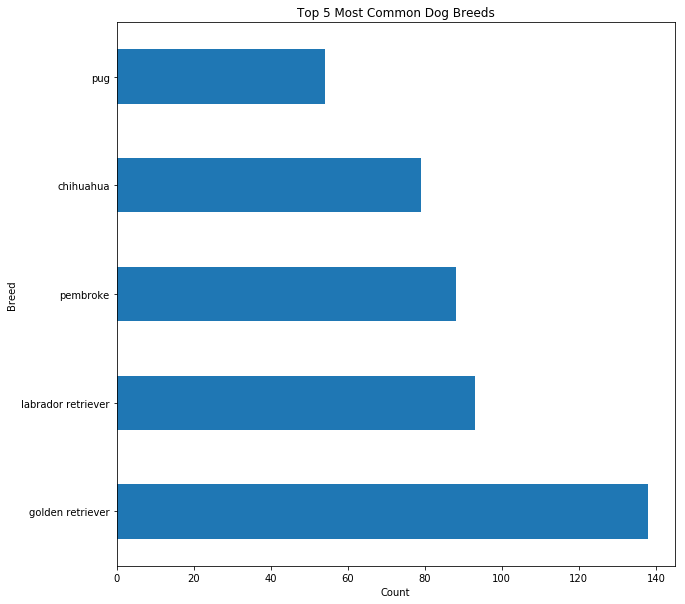

In [226]:
breeds_plot = dogs.breed.value_counts().head(5).plot('barh', title = 'Top 5 Most Common Dog Breeds');
breeds_plot.set_xlabel('Count')
breeds_plot.set_ylabel('Breed')
plt.savefig('./visuals/breeds-dist')

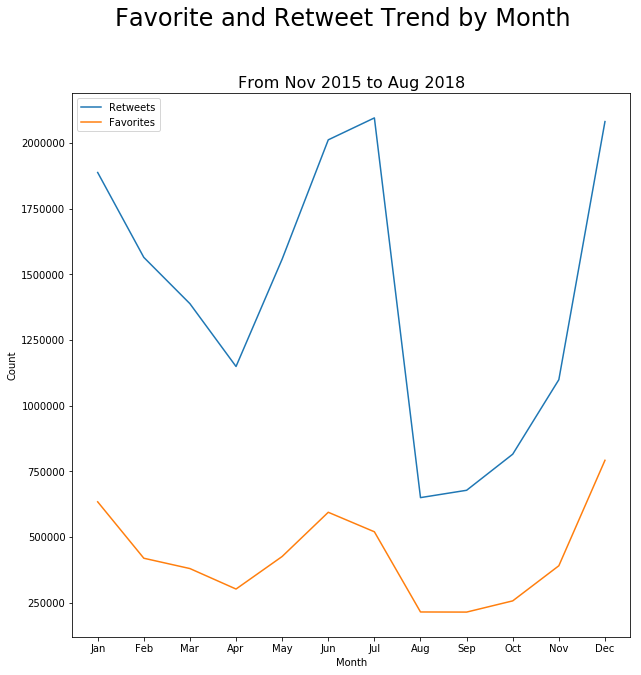

In [227]:
plt.subplots(1, sharex = True)

plt.plot(months_grouped.favorite_count)
plt.plot(months_grouped.retweet_count)

plt.xlabel('Month');
plt.ylabel('Count');
plt.legend(('Retweets', 'Favorites'))
plt.suptitle('Favorite and Retweet Trend by Month', fontsize = 24, y = 1);
plt.title('From Nov 2015 to Aug 2018', fontsize = 16);

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_i = [i for i in range(0, len(months))]
plt.xticks(months_i, months)

plt.savefig('./visuals/months-trend')

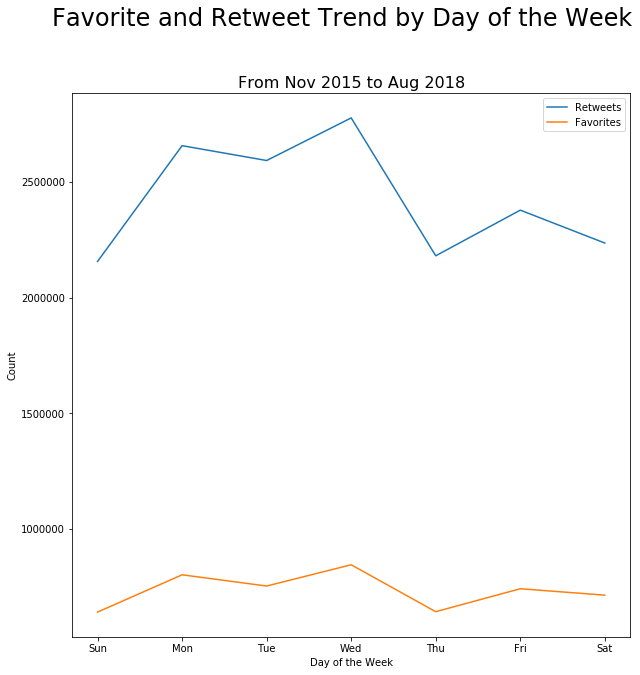

In [228]:
plt.subplots(1, sharex = True)

plt.plot(days_grouped.favorite_count)
plt.plot(days_grouped.retweet_count)

plt.xlabel('Day of the Week');
plt.ylabel('Count');
plt.legend(('Retweets', 'Favorites'))
plt.suptitle('Favorite and Retweet Trend by Day of the Week', fontsize = 24, y = 1);
plt.title('From Nov 2015 to Aug 2018', fontsize = 16);

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
days_i = [i for i in range(0, len(days))]
plt.xticks(days_i, days)

plt.savefig('./visuals/days-trend')

In [229]:
xi = dogs_grouped.proportion
y = dogs_grouped.mean_normalized_numerator

#create regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope * xi +intercept

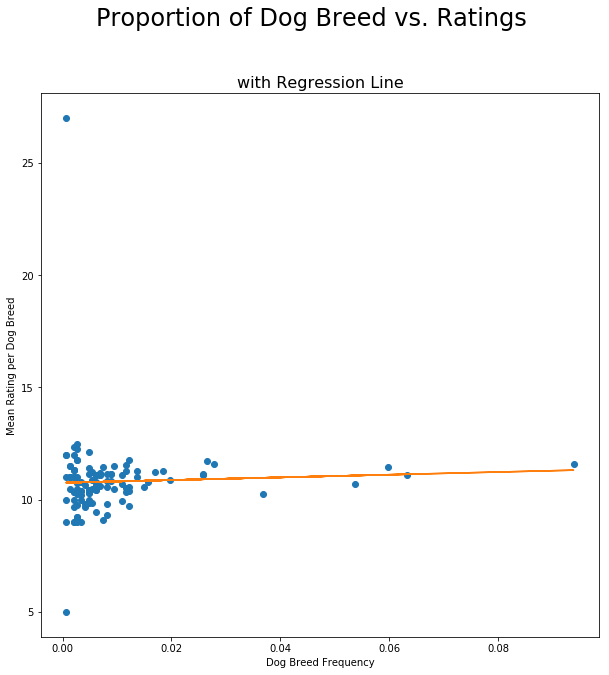

In [257]:
plt.plot(xi, y, 'o', xi, line);
plt.xlabel('Dog Breed Frequency')
plt.ylabel('Mean Rating per Dog Breed');
plt.suptitle('Proportion of Dog Breed vs. Ratings', fontsize = 24, y = 1);
plt.title('with Regression Line', fontsize = 16);

plt.savefig('./visuals/breed-ratings')

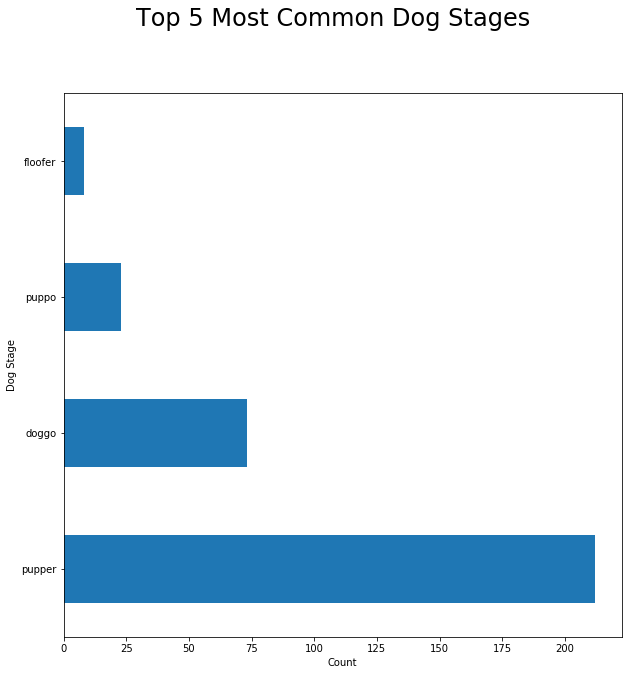

In [189]:
all_counts.plot('barh')

plt.suptitle('Top 5 Most Common Dog Stages', fontsize = 24, y = 1)
plt.xlabel('Count')
plt.ylabel('Dog Stage')
plt.savefig('./visuals/dog-stage-dist')

# Sources

https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

https://opensenselabs.com/blog/tech/entity-extraction-using-nlp-python (NTLK tokenization)

https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json

https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python

- https://github.com/gouravaich/wrangle-analyze-weratedogs-twitter/blob/master/Solution.ipynb (this is where I got the idea to add an error file)

https://stackoverflow.com/questions/3395138/using-multiple-arguments-for-string-formatting-in-python-e-g-s-s

https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin